In [2]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import datetime
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image
import mlflow



In [3]:
version = "v1.0"
data_url = "../data/flights.csv"

In [4]:
import sys  
#sys.path.insert(0, 'C:/Users/debgn/MLOPS/backend/src/')
sys.path.insert(0, '../backend/src/')
import data_preprocessing_training
from data_preprocessing_training import preprocess_and_split

In [5]:
from dotenv import load_dotenv
import os
load_dotenv("../backend/src/secret.env")

DagsHub_username = os.getenv("DAGHUB_USERNAME")
DagsHub_token=os.getenv("DAGHUB_PASSWORD")

In [6]:
import os
os.environ['MLFLOW_TRACKING_USERNAME']= DagsHub_username
os.environ['MLFLOW_TRACKING_PASSWORD'] = DagsHub_token

In [7]:
#setup mlflow
mlflow.set_tracking_uri('https://dagshub.com/deb.gnuito/MLOPS.mlflow') #your mlfow tracking uri
mlflow.set_experiment("flight-delay-experiment")

<Experiment: artifact_location='mlflow-artifacts:/485747da72104056a246976d414a7ec0', creation_time=1734056596207, experiment_id='0', last_update_time=1734056596207, lifecycle_stage='active', name='flight-delay-experiment', tags={}>

In [9]:
#read the data
df = pd.read_csv(data_url)

In [10]:
#shape of the data
df.shape

(5819079, 31)

In [11]:
#cleaning and preprocessing
X_train,X_test,y_train,y_test = preprocess_and_split(df)

Aucun changement détecté pour airport_encoder.pickle.


In [12]:
X_train.head()

,MONTH,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,SCHEDULED_TIME,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,...,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,AIRLINE_UA,AIRLINE_US,AIRLINE_VX,AIRLINE_WN
5272295,11,497,450,-6.0,80.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5678727,12,523,391,8.0,144.0,9.0,0.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2102837,5,576,393,-1.0,74.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5765214,12,502,489,-2.0,125.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
950249,3,346,373,-10.0,143.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
X_train.columns


Index(['MONTH', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DEPARTURE_DELAY',
       'SCHEDULED_TIME', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DEPARTURE_TIME_HOUR',
       'DEPARTURE_TIME_MINUTE', 'SCHEDULED_ARRIVAL_HOUR',
       'SCHEDULED_ARRIVAL_MINUTE', 'AIRLINE_AA', 'AIRLINE_AS', 'AIRLINE_B6',
       'AIRLINE_DL', 'AIRLINE_EV', 'AIRLINE_F9', 'AIRLINE_HA', 'AIRLINE_MQ',
       'AIRLINE_NK', 'AIRLINE_OO', 'AIRLINE_UA', 'AIRLINE_US', 'AIRLINE_VX',
       'AIRLINE_WN'],
      dtype='object')

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4655263 entries, 5272295 to 1692743
Data columns (total 28 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   MONTH                     int64  
 1   ORIGIN_AIRPORT            int32  
 2   DESTINATION_AIRPORT       int32  
 3   DEPARTURE_DELAY           float64
 4   SCHEDULED_TIME            float64
 5   AIR_SYSTEM_DELAY          float64
 6   SECURITY_DELAY            float64
 7   AIRLINE_DELAY             float64
 8   LATE_AIRCRAFT_DELAY       float64
 9   WEATHER_DELAY             float64
 10  DEPARTURE_TIME_HOUR       int64  
 11  DEPARTURE_TIME_MINUTE     int64  
 12  SCHEDULED_ARRIVAL_HOUR    int64  
 13  SCHEDULED_ARRIVAL_MINUTE  int64  
 14  AIRLINE_AA                float64
 15  AIRLINE_AS                float64
 16  AIRLINE_B6                float64
 17  AIRLINE_DL                float64
 18  AIRLINE_EV                float64
 19  AIRLINE_F9                float64
 20  AIRLINE_HA        

# 2. Machine Learning Modeling :


Etablison la **Baseline**

Le principe de la baseline en machine learning consiste à définir une référence simple ou une méthode triviale pour prédire les résultats. Cette référence sert à évaluer les performances d’un modèle de manière relative. Si un modèle ne fait pas mieux que cette baseline, il est considéré comme inefficace ou inutile, car il n'apporte pas de valeur ajoutée par rapport à une approche simple.

In [39]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Baseline predictions: moyenne des y_train
baseline_preds = y_train.agg('sum') / y_train.agg('count')

# Baseline errors
baseline_errors = abs(baseline_preds - y_test)

# 1. MAE - Mean Absolute Error
mae = np.mean(baseline_errors)
print('Mean Absolute Error (MAE):', round(mae, 2))

# 2. MSE - Mean Squared Error
mse = mean_squared_error([baseline_preds] * len(y_test), y_test)
print('Mean Squared Error (MSE):', round(mse, 2))

# 3. RMSE - Root Mean Squared Error
rmse = np.sqrt(mse)
print('Root Mean Squared Error (RMSE):', round(rmse, 2))

# 4. R² - Coefficient of Determination
r2 = r2_score(y_test, [baseline_preds] * len(y_test))
print('R² (Coefficient of Determination):', round(r2, 2))


Mean Absolute Error (MAE): 21.03
Mean Squared Error (MSE): 1530.77
Root Mean Squared Error (RMSE): 39.13
R² (Coefficient of Determination): -0.0


Il s’agit de notre erreur de base moyenne de 21.04 minutes de retard que nous souhaitons surmonter avec notre modèle de régression. Un model doit minimum avoir les erreur inférieur à celui de baseline sinon il sera rejetté

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb


# Définition correcte des modèles
Linear_Regression = LinearRegression()
model_xgb = xgb.XGBRegressor(n_estimators=100, random_state=42)
Decision_Tree = DecisionTreeRegressor(random_state=42)


In [15]:
# Entraînement des modèles
Linear_Regression.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)
Decision_Tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [16]:
# Prédictions sur les données de test
y_pred_lr = Linear_Regression.predict(X_test)
y_pred_xgb = model_xgb.predict(X_test)
y_pred_dt = Decision_Tree.predict(X_test)

### 1. Mean Squared Error (MSE) - Erreur quadratique moyenne
Le **MSE** mesure la moyenne des carrés des erreurs, c'est-à-dire la différence au carré entre la valeur réelle et la valeur prédite. Plus cette valeur est faible, meilleure est la performance du modèle. Cette valeur reste relative d'un cas ou à un autre 


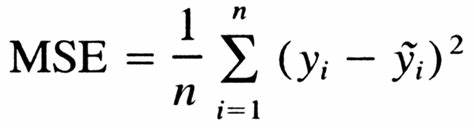

In [17]:
Image(filename="images/mse.jpg", width=500, height=100)

--------------------------------------------------------------------------------------------------------------------------

### 2. Root Mean Squared Error (RMSE) - Erreur quadratique moyenne racine
Le **RMSE** est simplement la racine carrée du MSE. Il est utilisé pour ramener l'échelle des erreurs à l'échelle originale des données, ce qui le rend plus facile à interpréter.

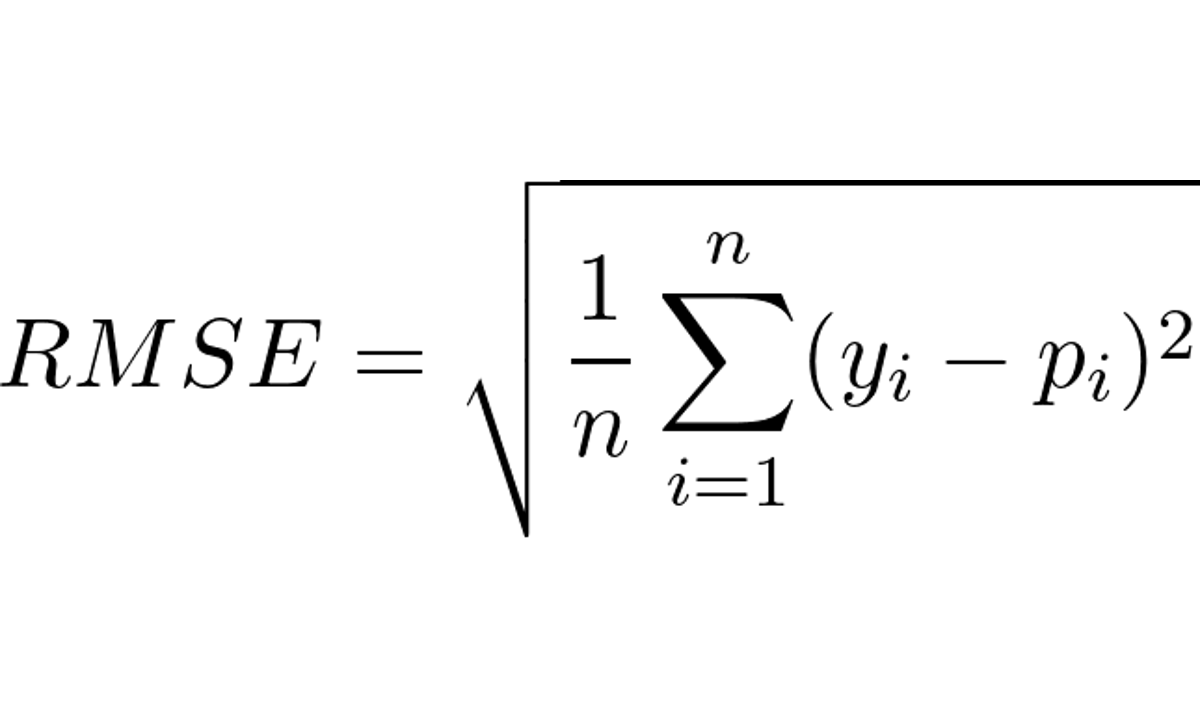

In [18]:
Image(filename="images/rmse.png", width=400, height=200)

--------------------------------------------------------------------------------------------------------------------------

### 3. Mean Absolute Error (MAE) - Erreur absolue moyenne
Le **MAE** mesure la moyenne des erreurs absolues, c'est-à-dire la différence absolue entre la valeur réelle et la valeur prédite.

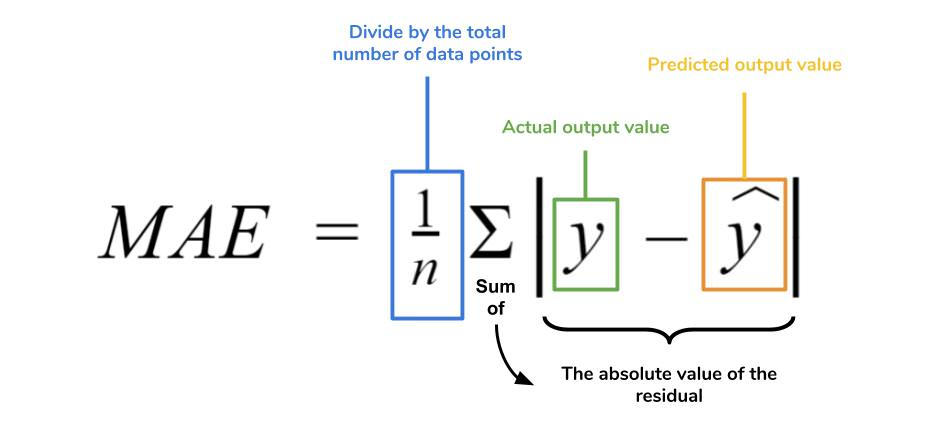

In [19]:
Image(filename="images/mae.jpg", width=500, height=200)

--------------------------------------------------------------------------------------------------------------------------

### R² Score (Coefficient de détermination)
Le R² score, également appelé coefficient de détermination, indique la proportion de la variance dans la variable cible qui est expliquée par le modèle. Il est calculé comme suit :

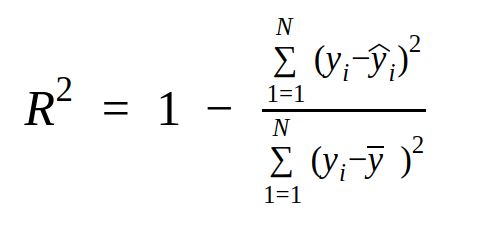

In [20]:
Image(filename="images/r2.png", width=500, height=200)

* Il montre dans quelle mesure le modèle capture la variance des données.
* Un R² proche de 1 indique que le modèle explique une grande partie de la variance des données, tandis qu'un R² proche de 0 indique que le modèle est inefficace.
* Le R² est très utile pour comparer des modèles de régression différents.

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Fonction pour calculer les métriques
def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R²": r2}

print("******************************Evaluation Linear Regression********************")
score_lr= evaluate_model(y_test,y_pred_lr)
for metric, value in score_lr.items():
    print(f"{metric}: {value:.4f}")

print("******************************Evaluation model_xgb********************")
score_xgb= evaluate_model(y_test,y_pred_xgb)
for metric, value in score_xgb.items():
    print(f"{metric}: {value:.4f}")

print("******************************Evaluation Decision_Tree********************")
score_dt= evaluate_model(y_test,y_pred_dt)
for metric, value in score_dt.items():
    print(f"{metric}: {value:.4f}")


******************************Evaluation Linear Regression********************
MAE: 7.2507
MSE: 87.0474
RMSE: 9.3299
R²: 0.9431
******************************Evaluation model_xgb********************
MAE: 6.0193
MSE: 79.1310
RMSE: 8.8956
R²: 0.9483
******************************Evaluation Decision_Tree********************
MAE: 6.9100
MSE: 105.1915
RMSE: 10.2563
R²: 0.9313


### **Finetuning du LinearRegression**

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Paramètres à tester
param_grid = {
    'fit_intercept': [True, False],  # Ajouter une constante ou non
}

# Initialisation du modèle
lr = LinearRegression()

# GridSearchCV
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Optimisation par R²
    cv=5,  # Validation croisée à 5 plis
    verbose=2
)

# Lancer la recherche
grid_search.fit(X_train, y_train)

best_params_lr = grid_search.best_params_
print("Meilleurs hyperparamètres (Random Search) : ", best_params_lr)
# Récupérer le meilleur modèle
best_model_lr = grid_search.best_estimator_


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .................................fit_intercept=True; total time=   9.8s
[CV] END .................................fit_intercept=True; total time=   8.3s
[CV] END .................................fit_intercept=True; total time=   8.5s
[CV] END .................................fit_intercept=True; total time=   8.6s
[CV] END .................................fit_intercept=True; total time=   8.7s
[CV] END ................................fit_intercept=False; total time=   9.0s
[CV] END ................................fit_intercept=False; total time=   9.3s
[CV] END ................................fit_intercept=False; total time=   8.8s
[CV] END ................................fit_intercept=False; total time=   9.8s
[CV] END ................................fit_intercept=False; total time=  10.7s
Meilleurs hyperparamètres (Random Search) :  {'fit_intercept': True}


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pred_lr1=best_model_lr.predict(X_test)
# Calcul des métriques
mse = mean_squared_error(y_test, pred_lr1)
mae = mean_absolute_error(y_test, pred_lr1)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred_lr1)
# Afficher les métriques
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")


MSE: 87.05
MAE: 7.25
RMSE: 9.33
R2 Score: 0.94


In [31]:
with mlflow.start_run(run_name='LinearRegression'):
    mlflow.log_param("data_url",data_url)
    mlflow.log_param("data_version",version)
    mlflow.log_param("input_rows",df.shape[0])
    mlflow.log_param("input_cols",df.shape[1])
    #model fitting and training
    lr= LinearRegression()

    mlflow.set_tag(key= "model",value="LinearRegression")
    params = lr.get_params()
    mlflow.log_params(params)
    lr.fit(X_train,y_train)
    train_features_name = f'{X_train=}'.split('=')[0]
    train_label_name = f'{y_test=}'.split('=')[0]
    mlflow.set_tag(key="train_features_name",value= train_features_name)
    mlflow.set_tag(key= "train_label_name",value=train_label_name)

    # Prédictions
    predictions = lr.predict(X_test)

    # Calcul des métriques
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    # Enregistrement des métriques
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE",  rmse)
    mlflow.log_metric("R2_Score", r2)

    # Enregistrer le modèle
    mlflow.sklearn.log_model(lr, artifact_path="ML_models")

# Afficher les métriques
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")


2024/12/13 18:54:17 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\debgn\AppData\Local\Temp\tmpkkh3d3tt\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
2024/12/13 18:54:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression at: https://dagshub.com/deb.gnuito/MLOPS.mlflow/#/experiments/0/runs/9e8ecf8a59e94365afcac174283db466
🧪 View experiment at: https://dagshub.com/deb.gnuito/MLOPS.mlflow/#/experiments/0
MSE: 87.05
MAE: 7.25
RMSE: 9.33
R2 Score: 0.94


In [37]:
lr_pred = lr.predict(X_test)

### **Finetuning du model_xgb**

In [27]:
import xgboost as xgb

# Initialiser le modèle XGBoost
xgb_model = xgb.XGBRegressor(random_state=42)

# Définir l'espace de recherche pour les hyperparamètres
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [50, 100, 200],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2]
}


from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Nombre d'itérations aléatoires
    scoring='r2',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)
best_params_xgb = random_search.best_params_
print("Meilleurs hyperparamètres (Random Search) : ", best_params_xgb)

# Récupérer le meilleur modèle
best_model_xgb = random_search.best_estimator_



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Meilleurs hyperparamètres (Random Search) :  {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}


In [28]:
y_pred_xgb = best_model_xgb.predict(X_test)

print("******************************Evaluation Best model xgboost********************")
score_best= evaluate_model(y_test,y_pred_xgb)
for metric, value in score_best.items():
    print(f"{metric}: {value:.4f}")

******************************Evaluation Best model xgboost********************
MAE: 5.9459
MSE: 77.3738
RMSE: 8.7962
R²: 0.9495


In [24]:
mlflow.sklearn.autolog(disable=True)

In [30]:
with mlflow.start_run(run_name='XGBRegressor'):
    mlflow.log_param("data_url",data_url)
    mlflow.log_param("data_version",version)
    mlflow.log_param("input_rows",df.shape[0])
    mlflow.log_param("input_cols",df.shape[1])
    #model fitting and training
    xgb_model = xgb.XGBRegressor(**best_params_xgb, random_state=42)

    mlflow.set_tag(key= "model",value="XGBRegressor")
    params = xgb_model.get_params()
    mlflow.log_params(params)
    xgb_model.fit(X_train,y_train)
    train_features_name = f'{X_train=}'.split('=')[0]
    train_label_name = f'{y_test=}'.split('=')[0]
    mlflow.set_tag(key="train_features_name",value= train_features_name)
    mlflow.set_tag(key= "train_label_name",value=train_label_name)

    # Prédictions
    predictions = xgb_model.predict(X_test)

    # Calcul des métriques
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    # Enregistrement des métriques
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE",  rmse)
    mlflow.log_metric("R2_Score", r2)

    # Enregistrer le modèle
    mlflow.sklearn.log_model(xgb_model, artifact_path="ML_models")

# Afficher les métriques
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")


2024/12/13 18:52:19 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\debgn\AppData\Local\Temp\tmpugcbbt7l\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
2024/12/13 18:52:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBRegressor at: https://dagshub.com/deb.gnuito/MLOPS.mlflow/#/experiments/0/runs/337c77bed65545bbb9f628bd01281728
🧪 View experiment at: https://dagshub.com/deb.gnuito/MLOPS.mlflow/#/experiments/0
MSE: 77.37
MAE: 5.95
RMSE: 8.80
R2 Score: 0.95


### **LSTM_Model**

In [32]:
with mlflow.start_run(run_name='LSTM_Model'):
    # Enregistrer les paramètres
    mlflow.log_param("data_url", data_url)
    mlflow.log_param("data_version", version)
    mlflow.log_param("input_rows", df.shape[0])
    mlflow.log_param("input_cols", df.shape[1])

    # Créer et entraîner le modèle LSTM
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))  # LSTM
    model.add(Dense(units=1))  # Couche de sortie

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Enregistrer les hyperparamètres
    mlflow.set_tag(key="model", value="LSTM")
    params = {"units": 50, "optimizer": "adam", "loss": "mean_squared_error"}
    mlflow.log_params(params)

    # Entraîner le modèle
    model.fit(X_train, y_train, epochs=4, batch_size=128, verbose=1)

    # Enregistrer les noms des caractéristiques d'entrée et de sortie
    train_features_name = f'{X_train=}'.split('=')[0]
    train_label_name = f'{y_train=}'.split('=')[0]
    mlflow.set_tag(key="train_features_name", value=train_features_name)
    mlflow.set_tag(key="train_label_name", value=train_label_name)
